In [31]:
import sys
sys.path.append('..')

import transformers
import torch
import tqdm

import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utility.minio import cmd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from training_worker.ab_ranking.model.ab_ranking_elm_v1 import ABRankingELMModel
from training_worker.ab_ranking.model.ab_ranking_linear import ABRankingModel
from transformers import CLIPTokenizer, CLIPTextModel
from sklearn.metrics import confusion_matrix

transformers.logging.set_verbosity_error()

## Loading models, CSV dataset

In [17]:
tokenizer = CLIPTokenizer.from_pretrained('../../kcg-ml-n-grams/weights/txt_emb_tokenizer')
model = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14').eval().to('cuda')

def load_models(
    elm_model_weights,
    linear_model_weights
):
    elm_model = ABRankingELMModel(768)
    elm_model.load(elm_model_weights)

    linear_model = ABRankingModel(768)
    linear_model.load(linear_model_weights)

    return elm_model, linear_model

elm_model, linear_model = load_models(
    '../../kcg-ml-n-grams/weights/2023-11-03-00-score-elm-v1-embedding-positive.pth',
    '../../kcg-ml-n-grams/weights/2023-11-03-00-score-linear-embedding-positive.pth'
)

def embed(prompt):
    with torch.no_grad():
        token_encoding = tokenizer(prompt, return_length=True, return_tensors='pt')
        embedding = model(input_ids=token_encoding['input_ids'].to('cuda')).last_hidden_state[0]

    return embedding

def score_prompt(prompt):
    embedding = embed(prompt)
    embedding = embedding.unsqueeze(0).permute(0, 2, 1)
    score = elm_model.predict_positive_or_negative_only(embedding).item()

    return score

inputs_shape= 768


In [7]:
df = pd.read_csv('../../kcg-ml-n-grams/output/20231108_env_1/environment_data.csv')
df['positive_tokens'] = df['positive_prompt'].apply(lambda x: x.split(', '))

df_phrase = pd.read_csv('../../kcg-ml-n-grams/output/20231107_env_1/environment_1-gram.csv')
df_phrase.head()

,phrase str,token_length,positive count,negative count
0,seductive,3,8,0
1,!,3,16,0
2,!bodycam footage of satan being arrested in hell,12,1,0
3,!draw anime,5,1,0
4,""" is captured in a pose that accentuates her s...",20,1,0


### Filter prompts

In [20]:
to_keep = []
phrase_list = df_phrase['phrase str'].tolist()

for idx, row in df.iterrows():
    tokens = row['positive_tokens']
    token_length = len(tokenizer.tokenize(row['positive_prompt']))

    # remove prompts with phrases not in the phrase list (phrase list is already filtered)
    # remove prompts where token length is more than 75
    if set(tokens).issubset(phrase_list) and token_length <= 75:
        to_keep.append(idx)

df_filtered = df.iloc[to_keep]

## Create dataset

In [22]:
# visualize the top prompts

df_filtered['score'] = df_filtered['positive_prompt'].apply(lambda x: score_prompt(x))
df_sort = df_filtered.sort_values('score', ascending=False)
df_sort.head()

,job_uuid,creation_time,dataset,file_path,file_hash,positive_prompt,negative_prompt,positive_tokens,score
12047,5de5e72b-a9af-47be-a26c-50166fb00043,2023-10-24 09:14:31,environmental,environmental/0018/017599_embedding.msgpack,9b88333a0a7746859c22750c703530625683add0e042c9...,"video game, environmental, 2D environmental, c...","multiple limbs, terrible","[video game, environmental, 2D environmental, ...",2600.142090
9751,889aa3d4-0ee3-4210-a89c-7f720155cffc,2023-10-23 19:23:24,environmental,environmental/0015/014877_embedding.msgpack,694f63ba84bd9d563469d24712b15bd7bcea8190452abf...,"level design, tile based environment, concept ...","missing arms, (blurry:1.7), lowres, low qualit...","[level design, tile based environment, concept...",2558.600586
9690,8cad9af8-3120-456a-8e08-8a123abc1ff0,2023-10-23 19:22:40,environmental,environmental/0015/014804_embedding.msgpack,f2c4cbccd49ee0e8bee00aa6626aa22a948dbcaf611044...,"concept art, level design, side view, 2D envir...","(poorly drawn hands:1.5), odd, mutated hands, ...","[concept art, level design, side view, 2D envi...",2554.009277
9163,9de8ca97-df58-47e3-bb12-0c6e24edf3a3,2023-10-23 15:48:37,environmental,environmental/0013/012697_embedding.msgpack,70ead603f69874a8e6eb4fe8052e1248c995f31cc81469...,"2D side scrolling video game, tile based envir...","sketches, (signature:1.2), (inaccurate limb:1....","[2D side scrolling video game, tile based envi...",2533.832520
7012,8f9b364a-5e58-434f-b036-7318fa561fae,2023-10-21 02:39:04,environmental,environmental/0010/009786_embedding.msgpack,d715d03446579b7fe6ef955782da69ad9555ac06e0cc91...,"2D environmental art side scrolling, level des...","normal quality, worst quality, anime, bad hand...","[2D environmental art side scrolling, level de...",2533.770508


For each prompt:
1. Loop through every phrase
2. Remove phrase (keep all other phrases) and compute score    

Model will be trained to predict if score goes up or down after phrase removal  
XGBoost model::
- Input: Original prompt embedding + Removed phrase embedding
- Output: Probability of score going up (0 for score going down)

In [24]:
dataset = []
pbar = tqdm.tqdm(df_sort.iterrows(), total=len(df_sort))
for idx, row in pbar:
    tokens = row['positive_tokens']
    prompt_score = row['score']
    prompt_embedding = embed(row['positive_prompt'])
    prompt_embedding = torch.mean(prompt_embedding, dim=0).cpu().numpy()

    # remove phrase
    for to_remove in tokens:
        updated_prompt = [element for element in tokens if element != to_remove]

        to_remove_embedding = torch.mean(embed(to_remove), dim=0).cpu().numpy()
        updated_prompt_embedding = embed(', '.join(updated_prompt))

        updated_prompt_score = score_prompt(', '.join(updated_prompt))

        # concatenate original prompt embedding and emebedding of removed phrase
        # this will be used as model input
        X = np.concatenate([prompt_embedding, to_remove_embedding])

        data = {
            'prompt': row['positive_prompt'],
            'removed': to_remove,
            'X': X,
            'prompt_score': prompt_score,
            'new_score': updated_prompt_score,
            'delta': prompt_score - updated_prompt_score
        }

        dataset.append(data)
    pbar.update(1)

100%|██████████| 6620/6620 [27:17<00:00,  4.04it/s]


Create labels for dataset.  
delta = prompt_score - new_score  
y = 1 if score increased after removal else 0

In [26]:
# create prediction labels
dataset = pd.DataFrame(dataset)
dataset['y'] = dataset['delta'] < 0
dataset['y'] = dataset['y'].astype(int)
dataset.head()

,prompt,removed,X,prompt_score,new_score,delta,y
0,"video game, environmental, 2D environmental, c...",video game,"[0.45556265, -0.18199353, 0.2045647, -0.155226...",2600.14209,2502.464844,97.677246,0
1,"video game, environmental, 2D environmental, c...",environmental,"[0.45556265, -0.18199353, 0.2045647, -0.155226...",2600.14209,2573.695312,26.446777,0
2,"video game, environmental, 2D environmental, c...",2D environmental,"[0.45556265, -0.18199353, 0.2045647, -0.155226...",2600.14209,2556.281738,43.860352,0
3,"video game, environmental, 2D environmental, c...",concept art,"[0.45556265, -0.18199353, 0.2045647, -0.155226...",2600.14209,2541.579102,58.562988,0
4,"video game, environmental, 2D environmental, c...",level design,"[0.45556265, -0.18199353, 0.2045647, -0.155226...",2600.14209,2453.330078,146.812012,0


In [27]:
# check the stats for delta
dataset.describe()

,prompt_score,new_score,delta,y
count,115440.000000,115440.000000,115440.000000,115440.000000
mean,1470.051892,1439.352943,30.698949,0.327659
std,380.326784,386.346383,85.688224,0.469362
min,333.935303,-332.605255,-589.415405,0.000000
25%,1184.727051,1148.657532,-10.101593,0.000000
50%,1479.356323,1446.296326,18.753418,0.000000
75%,1771.419800,1747.326752,58.624451,1.000000
max,2600.142090,2673.763184,2203.940704,1.000000


Split dataset for training

In [28]:
X = np.stack(dataset['X'].values)
y = dataset['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

In [29]:
params = {
    'objective': 'binary:logistic',  # for binary classification
    'eval_metric': 'logloss',  # log-likelihood loss
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model
num_round = 200  # number of boosting rounds
model = xgb.train(params, train_data, num_round)

In [30]:
# Make predictions on the test set
y_pred_prob = model.predict(test_data)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7639033264033264
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84     15473
           1       0.70      0.49      0.58      7615

    accuracy                           0.76     23088
   macro avg       0.74      0.69      0.71     23088
weighted avg       0.76      0.76      0.75     23088



<Figure size 600x600 with 0 Axes>

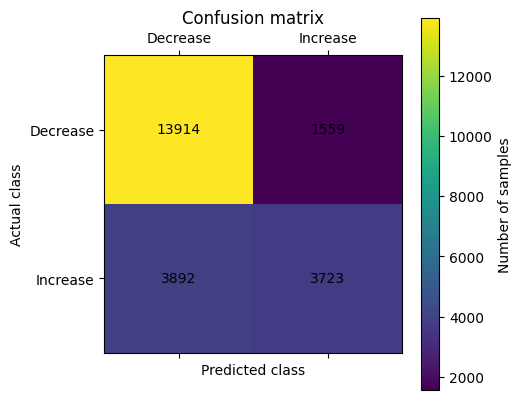

In [34]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.matshow(cm, cmap='viridis')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Confusion matrix')
plt.colorbar(label='Number of samples')
plt.xticks([0, 1], ['Decrease', 'Increase'])
plt.yticks([0, 1], ['Decrease', 'Increase'])

# Add actual values to the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.annotate(str(cm[i][j]), xy=(j, i), ha='center', va='center')

plt.show()